# `mdmm` tutorial
The purpose of this notebook is to guide you to train a model with a loss function of several parameters in a proper mathematical way. The idea comes from the paper [Constrained Differential Optimization](https://papers.nips.cc/paper/1987/file/a87ff679a2f3e71d9181a67b7542122c-Paper.pdf), and the implementation from the [mdmm package Github](https://github.com/crowsonkb/mdmm)

The guide is best illustrated through the **[VICReg](https://arxiv.org/abs/2105.04906)** example where your input is split into two views and you are asked to minimize three loss terms: `variance`, `invariance` and `covariance`.

In [1]:
! pip install mdmm

In [2]:
import warnings
import numpy as np
import mdmm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.conv import GravNetConv

warnings.simplefilter("ignore", UserWarning)

# define the global base device
if torch.cuda.device_count():
    device = torch.device("cuda:0")
    print(f"Will use {torch.cuda.get_device_name(device)}")
else:
    device = "cpu"
    print("Will use cpu")

Will use NVIDIA A10


Load a processed `.pt` clic file.

In [3]:
data = torch.load("/../ssl-jet-vol-v2/toptagging/train/processed/data_0.pt")
print(f"num of clic events {len(data)}")

num of clic events 100001


In [4]:
# build a data loader
batch_size = 256

loader = DataLoader(data, batch_size, shuffle=True)
for batch in loader:
    print(f"A single event: \n {batch}")
    break

input_dim = batch.x.shape[-1]

A single event: 
 DataBatch(x=[12559, 7], y=[256], batch=[12559], ptr=[257])


# Preparation

In [5]:
def translate_jets(batch, width=1.0, device='cpu'):
    width = 1.0
    bb = batch.clone()
    bb = bb.to("cpu")
    X = bb.x.numpy()
    ptp_eta = np.ptp(X[:,0], axis=-1, keepdims=True)
    ptp_phi = np.ptp(X[:,1], axis=-1, keepdims=True)
    low_eta  = -width*ptp_eta
#     print(f"low eta: {low_eta}")
    high_eta = +width*ptp_eta
#     print(f"high eta: {high_eta}")
    low_phi = np.maximum(-width*ptp_phi, -np.pi-np.min(X[:,1]).reshape(ptp_phi.shape))
#     print(f"low phi: {low_phi}")
    high_phi = np.minimum(+width*ptp_phi, +np.pi-np.max(X[:,1]).reshape(ptp_phi.shape))
#     print(f"high phi: {high_phi}")
    shift_eta_batch = np.random.uniform(low=low_eta, high=high_eta, size=(bb.y.shape[0], 1))  
    shift_phi_batch = np.random.uniform(low=low_phi, high=high_phi, size=(bb.y.shape[0], 1))  
    
    # To make sure that the components of each jet get shifted by the same amount
    for i in range(len(bb)):
        X_jet = bb[i].x.numpy()
        shift_eta_jet = np.ones((X_jet.shape[0], 1)) * shift_eta_batch[i]
        shift_phi_jet = np.ones((X_jet.shape[0], 1)) * shift_phi_batch[i]
        if i == 0:
            shift_eta = shift_eta_jet
            shift_phi = shift_phi_jet
        else:
            shift_eta = np.concatenate((shift_eta, shift_eta_jet))
            shift_phi = np.concatenate((shift_phi, shift_phi_jet))

    shift = np.hstack((shift_eta, shift_phi, np.zeros((X.shape[0], 5))))
    new_X = X + shift
    new_X = torch.tensor(new_X).to(device)
    bb.x = new_X
    return bb.to(device)

In [6]:
def rotate_jets(batch, device):
    bb = batch.clone()
    bb = bb.to("cpu")
    rot_angle = np.random.rand(len(bb))*2*np.pi
#     print(rot_angle)
    c = np.cos(rot_angle)
    s = np.sin(rot_angle)
    o = np.ones_like(rot_angle)
    z = np.zeros_like(rot_angle)
    rot_matrix = np.array([[z, c, -s], [z, s, c], [o, z, z]])  # (3, 3, 100)
    rot_matrix = rot_matrix.transpose(2,0,1)  # (100, 3, 3)

    for i in range(len(bb)):
        x_ = bb[i].x[:,:3]
        new_x = np.einsum('ij,jk', bb[i].x[:,:3], rot_matrix[i])  # this is somehow (pT, eta', phi')
        new_x[:, [0,2]] = new_x[:, [2, 0]] 
        new_x[:, [0,1]] = new_x[:, [1, 0]] # now (phi', eta', pT)
        
        if i == 0:
            new_X = new_x
        else:
            new_X = np.concatenate((new_X, new_x), axis=0)

    new_X = torch.tensor(new_X).to(device)
    bb.x[:,:3] = new_X
    return bb.to(device)

In [7]:
def augmentation(batch, device="cpu"):
    """
    Takes events of the form Batch() and applies a series of augmentations. 
    The output will have the same shape as the input
    """
    batch_aug = translate_jets(batch, device=device)
    batch_aug = rotate_jets(batch_aug, device=device)
    return batch_aug

In [8]:
def event_augmentation(batch, device="cpu"):
    """
    Takes events of the form Batch() and splits them into two Batch() objects representing the two views.

    In this example, the two views are translated and then rotated by different amounts
    """
    view1 = augmentation(batch, device=device)
    view2 = augmentation(batch, device=device)

    return view1, view2

In [9]:
view1, view2 = event_augmentation(batch, device)
print(f"view1: {view1}")
print(f"view2: {view2}")

view1: DataBatch(x=[12559, 7], y=[256], batch=[12559], ptr=[257])
view2: DataBatch(x=[12559, 7], y=[256], batch=[12559], ptr=[257])


In [10]:
print(view2[0].x[:3])

tensor([[-1.4918, -0.0844,  5.1652,  5.1990, -1.2191, -1.2373,  0.0990],
        [-1.7689,  0.1323,  4.7652,  4.7657, -1.6191, -1.6706,  0.2661],
        [-1.5067, -0.0889,  3.4224,  3.4523, -2.9619, -2.9840,  0.0857]],
       device='cuda:0', dtype=torch.float64)


In [11]:
print(view1[0].x[:3])

tensor([[ 2.5563e-01, -7.0102e-01,  5.1652e+00,  5.1990e+00, -1.2191e+00,
         -1.2373e+00,  9.9016e-02],
        [ 3.0050e-03, -9.4581e-01,  4.7652e+00,  4.7657e+00, -1.6191e+00,
         -1.6706e+00,  2.6613e-01],
        [ 2.5806e-01, -7.1645e-01,  3.4224e+00,  3.4523e+00, -2.9619e+00,
         -2.9840e+00,  8.5700e-02]], device='cuda:0', dtype=torch.float64)


# Setup the VICReg model (GravNet-based)

In [12]:
class VICReg(nn.Module):
    def __init__(self, encoder, decoder):
        super(VICReg, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

        self.augmentation = event_augmentation
        self.device = device

    def forward(self, event):
        # seperate the two views
        view1, view2 = self.augmentation(event, self.device)

        # encode to retrieve the representations
        view1_representations, view2_representations = self.encoder(view1, view2)
#         print(f"view 1 representations: {view1_representations}")
#         print(f"view 2 representations: {view2_representations}")

        # simple MLP decoder
        view1_embeddings = self.decoder(view1_representations)
        view2_embeddings = self.decoder(view2_representations)

        # global pooling to be able to compute a loss between views of different dimensionalities
        view1_embeddings = global_mean_pool(view1_embeddings, view1.batch)
        view2_embeddings = global_mean_pool(view2_embeddings, view2.batch)

        return view1_embeddings, view2_embeddings


class ENCODER(nn.Module):
    """The Encoder part of VICReg which attempts to learn useful latent representations of the two views."""

    def __init__(
        self,
        input_dim,
        width=126,
        embedding_dim=34,
        num_convs=2,
    ):
        super(ENCODER, self).__init__()

        self.act = nn.ELU

        # 1. same MLP for each view
        self.nn1 = nn.Sequential(
            nn.Linear(input_dim, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, embedding_dim),
        )
        self.nn2 = self.nn1

        # 2. same GNN for each view
        self.convs = nn.ModuleList()
        for i in range(num_convs):
            self.convs.append(
                GravNetConv(
                    embedding_dim,
                    embedding_dim,
                    space_dimensions=4,
                    propagate_dimensions=22,
                    k=8,
                )
            )

    def forward(self, view1, view2):
        view1_representations = self.nn1(view1.x.float())
        view2_representations = self.nn2(view2.x.float())

        # perform a series of graph convolutions
        for num, conv in enumerate(self.convs):
            view1_representations = conv(view1_representations, view1.batch)
            view2_representations = conv(view2_representations, view2.batch)

        return view1_representations, view2_representations


class DECODER(nn.Module):
    """The Decoder part of VICReg which attempts to expand the learned latent representations
    of the two views into a space where a loss can be computed."""

    def __init__(
        self,
        embedding_dim=34,
        width=126,
        output_dim=200,
    ):
        super(DECODER, self).__init__()

        self.act = nn.ELU

        # DECODER
        self.expander = nn.Sequential(
            nn.Linear(embedding_dim, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, output_dim),
        )

    def forward(self, x):
        return self.expander(x)


In [13]:
vicreg_encoder = ENCODER(input_dim, embedding_dim=34)
vicreg_decoder = DECODER(embedding_dim=34, output_dim=200)

vicreg = VICReg(vicreg_encoder, vicreg_decoder)
vicreg.to(device)

VICReg(
  (encoder): ENCODER(
    (nn1): Sequential(
      (0): Linear(in_features=7, out_features=126, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=126, out_features=126, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=126, out_features=126, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=126, out_features=34, bias=True)
    )
    (nn2): Sequential(
      (0): Linear(in_features=7, out_features=126, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=126, out_features=126, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=126, out_features=126, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=126, out_features=34, bias=True)
    )
    (convs): ModuleList(
      (0): GravNetConv(34, 34, k=8)
      (1): GravNetConv(34, 34, k=8)
    )
  )
  (decoder): DECODER(
    (expander): Sequential(
      (0): Linear(in_features=34, out_features=126, bias=True)
      (1): ELU(alpha=1.0)
    

# Setup the loss terms

In [14]:
def off_diagonal(x):
    """Copied from VICReg paper github https://github.com/facebookresearch/vicreg/"""
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()


class CovLoss(nn.Module):
    def forward(self, view1, view2):
        N = view1.size(0)  # batch size
        D = view1.size(1)  # dim of representations

        view1 = view1 - view1.mean(dim=0)
        view2 = view2 - view2.mean(dim=0)

        cov_view1 = (view1.T @ view1) / (N - 1)
        cov_view2 = (view2.T @ view2) / (N - 1)

        loss = off_diagonal(cov_view1).pow_(2).sum().div(D) + off_diagonal(cov_view2).pow_(2).sum().div(D)
        return loss


class VarLoss(nn.Module):
    def forward(self, view1, view2):
        view1 = view1 - view1.mean(dim=0)
        view2 = view2 - view2.mean(dim=0)

        # variance loss
        std_view1 = torch.sqrt(view1.var(dim=0) + 1e-10)
        std_view2 = torch.sqrt(view2.var(dim=0) + 1e-10)

        loss = torch.mean(F.relu(1 - std_view1)) / 2 + torch.mean(F.relu(1 - std_view2)) / 2
        return loss

In [15]:
crit_invar = nn.MSELoss()
crit_var = VarLoss()
crit_cov = CovLoss()

max_var = 1e-5 * batch_size
max_cov = 50 * batch_size

constraints = []
constraints.append(mdmm.MaxConstraint(lambda: crit_var(view1_embeddings, view2_embeddings), max_var))
constraints.append(mdmm.MaxConstraint(lambda: crit_cov(view1_embeddings, view2_embeddings), max_cov, scale=1e4))

mdmm_module = mdmm.MDMM(constraints)
optimizer = mdmm_module.make_optimizer(vicreg.parameters(), lr=1e-4)

# Run a training loop

In [16]:
losses_inv, losses_var, losses_cov, losses_reg = [], [], [], []

for i, batch in enumerate(loader):
    # run VICReg forward pass to get the embeddings
    view1_embeddings, view2_embeddings = vicreg(batch.to(device))

    # compute the invariance loss which is contrained by the other loss terms
    loss = batch_size * crit_invar(view1_embeddings, view2_embeddings)
#     print(f"invariance loss: {loss * 1e4:.2f}")
    losses_inv.append(loss.detach().item() * 1e4)
    loss_var = batch_size * crit_var(view1_embeddings, view2_embeddings)
#     print(f"variance loss: {loss_var * 1e4:.2f}")
    losses_var.append(loss_var.detach().item() * 1e4)
    loss_cov = batch_size * crit_cov(view1_embeddings, view2_embeddings)
#     print(f"covariance loss: {loss_cov * 1e4:.2f}")
    losses_cov.append(loss_cov.detach().item() * 1e4)
#     print(f"max var: {max_var * 1e4}")
#     print(f"max cov: {max_cov * 1e4}")

    mdmm_return = mdmm_module(loss)

    # backprop
    for param in vicreg.parameters():
        param.grad = None
    mdmm_return.value.backward()
#     print(mdmm_return)

    optimizer.step()
#     print(f"constrained invariance loss: {loss.detach():.2f}")
    print(f"constrained invariance loss: {loss.detach()* 1e4:.2f}")
    losses_reg.append(loss.detach().item() * 1e4)

    if i == 100:
        break
#     print("-----------")

constrained invariance loss: 9.24
constrained invariance loss: 7.48
constrained invariance loss: 5.58
constrained invariance loss: 4.94
constrained invariance loss: 3.27
constrained invariance loss: 3.68
constrained invariance loss: 3.01
constrained invariance loss: 2.65
constrained invariance loss: 2.66
constrained invariance loss: 2.39
constrained invariance loss: 2.35
constrained invariance loss: 2.73
constrained invariance loss: 2.01
constrained invariance loss: 2.27
constrained invariance loss: 1.85
constrained invariance loss: 2.03
constrained invariance loss: 1.70
constrained invariance loss: 1.95
constrained invariance loss: 1.49
constrained invariance loss: 1.23
constrained invariance loss: 1.20
constrained invariance loss: 1.29
constrained invariance loss: 1.46
constrained invariance loss: 1.05
constrained invariance loss: 1.38
constrained invariance loss: 1.53
constrained invariance loss: 1.32
constrained invariance loss: 1.22
constrained invariance loss: 1.15
constrained in

In [17]:
import matplotlib
import matplotlib.pyplot as plt
# plt.plot(losses)

In [27]:
print(f"max var * 1e4: {max_var * 1e4}")
print(f"max cov * 1e4: {max_cov * 1e4}")

max var * 1e4: 25.6
max cov * 1e4: 128000000.0


Text(0.5, 1.0, 'Invariance loss * 1e4')

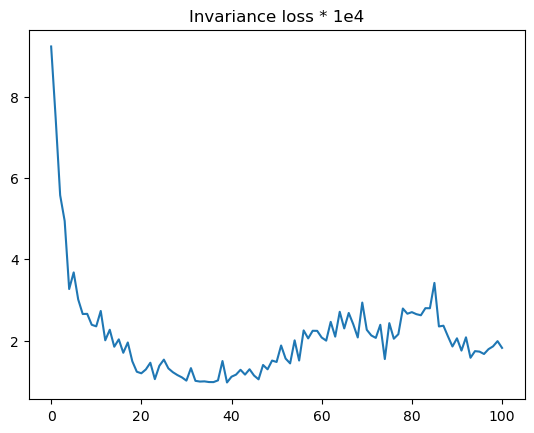

In [22]:
plt.plot(losses_inv)
plt.title("Unconstrained Invariance loss * 1e4")

Text(0.5, 1.0, 'Variance loss * 1e4')

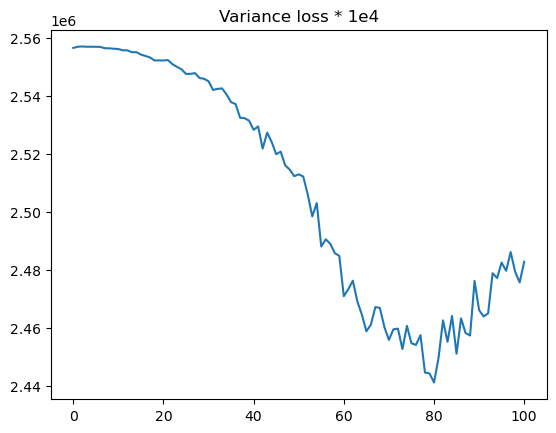

In [23]:
plt.plot(losses_var)
plt.title("Variance loss * 1e4")

Text(0.5, 1.0, 'Covariance loss * 1e4')

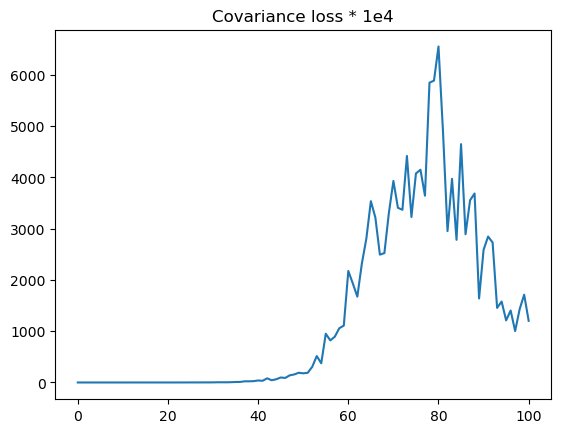

In [24]:
plt.plot(losses_cov)
plt.title("Covariance loss * 1e4")

Text(0.5, 1.0, 'Constrained Invariance loss * 1e4')

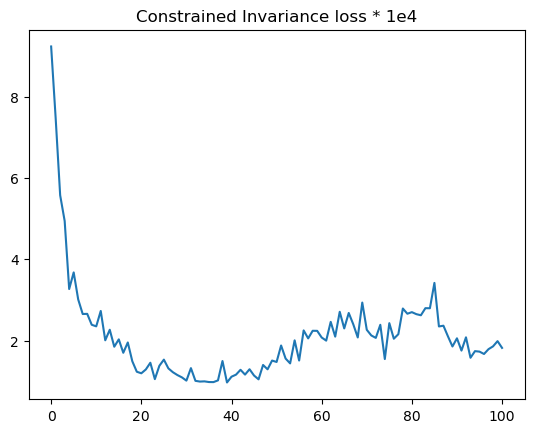

In [25]:
plt.plot(losses_reg)
plt.title("Constrained Invariance loss * 1e4")